# Capstone Project: Malacious URL detection using Machine Learning and Artificial Intelligence


### Business Understanding

**Overview**: The Web has long become a major platform for online criminal activities. URLs are used as the main vehicle in this domain. To counter this issues security community focused its efforts on developing techniques for mostly blacklisting of malicious URLs. While successful in protecting users from known malicious domains, this approach only solves part of the problem. The new malicious URLs that sprang up all over the web in masses commonly get a head start in this race. . In this project I explored a lightweight approach to detection and categorization of the malicious URLs according to their attack type and show that lexical analysis is effective and efficient for proactive detection of these URLs.



### Data Understanding
#### Dataset Overview
The Malicious URL dataset was taken from Kaggle The dataset include a large number of examples of Malicious URLs so that a machine learning-based model can be developed to identify malicious urls and stop them in advance before infecting computer system or spreading through inteinternet.


#### Collect Initial Data
This dataset has been created by combining a number of a different datasets together such as ISCx-URL2016,faizan git repo and from bad URL reporting sites such as PhishTank.


#### Describe Data
The dataset consists of 651,191 URLs, out of which 428103 benign or safe URLs, 96457 defacement URLs, 94111 phishing URLs, and 32520 malware URLs. It has two columns comprising of url and a type which signifies the class of maliciousness

The data represents 17 marketing campaigns occured between May 2008 and Nov 2010, corresponding to a total of 79354 contacts.

#### Read in the Data

Use pandas to read in the dataset `malicious_phish.csv`.

In [72]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"
import time
import warnings
from colorama import Fore
from urllib.parse import urlparse
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score, precision_score, recall_score, roc_auc_score,roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.compose import make_column_transformer
from sklearn.metrics import precision_recall_fscore_support



# Ignore warnings
warnings.filterwarnings('ignore')

In [73]:
#Collect Initial Data
df = pd.read_csv('../data/malicious_phish.csv')


In [74]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [75]:
df.shape

(651191, 2)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [77]:
df.describe

<bound method NDFrame.describe of                                                       url        type
0                                        br-icloud.com.br    phishing
1                     mp3raid.com/music/krizz_kaliko.html      benign
2                         bopsecrets.org/rexroth/cr/1.htm      benign
3       http://www.garage-pirenne.be/index.php?option=...  defacement
4       http://adventure-nicaragua.net/index.php?optio...  defacement
...                                                   ...         ...
651186            xbox360.ign.com/objects/850/850402.html    phishing
651187       games.teamxbox.com/xbox-360/1860/Dead-Space/    phishing
651188         www.gamespot.com/xbox360/action/deadspace/    phishing
651189      en.wikipedia.org/wiki/Dead_Space_(video_game)    phishing
651190          www.angelfire.com/goth/devilmaycrytonite/    phishing

[651191 rows x 2 columns]>

Understanding the Features

1. url-type of urls
2. type -type of urls ['benign', 'defacement', 'phishing', 'malware]

###  Explore & Verify data 
The dataset dosen't contain null values
1. Check for Null values: No null values found 
2. Determine the unique values for each columns

In [78]:
#Checking for NaN values
df.isnull().sum()

url     0
type    0
dtype: int64

In [79]:
# Describe data
df.describe(include = ['object'])

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [80]:
#Explore and verify data
count = df.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [81]:
x=count.index
x

Index(['benign', 'defacement', 'phishing', 'malware'], dtype='object')

#### Extract and prepare data

Removing www from the URL

In [82]:
#Extract data
df['url'] = df['url'].replace('www.', '', regex=True)
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [83]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


### Data Preparation

After my initial exploration and fine tuning of the dataset, it is time to prepare,extract data  prior to modeling

#### Feature Engineering

In [84]:
#Extracting category from URL type
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
df['Category'] = df['type']
df = df.replace(rem)
df.head(5)

,url,type,Category
0,br-icloud.com.br,phishing,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [85]:
#Create a seperate column with lenght of URL
df['url_len'] = df['url'].apply(lambda x: len(str(x)))
df.head(5)


,url,type,Category,url_len
0,br-icloud.com.br,phishing,2,16
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235


Extract and create column domain


In [86]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain
df['domain'] = df['url'].apply(lambda i: process_tld(i))
df.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


Extract and create columns using special characters

In [87]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    df[a] = df['url'].apply(lambda i: i.count(a))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [88]:
# urlparse():This function parses a URL into six components, returning a 6-tuple. 
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1


Extract secure URL

In [89]:
def httpSecure(url):
    htp = urlparse(url).scheme #It supports the following URL schemes: file , ftp , gopher , hdl , 
                               #http , https ... from urllib.parse
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['https'] = df['url'].apply(lambda i: httpSecure(i))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1,0


Counts the number of digit characters in a URL

In [90]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['digits']= df['url'].apply(lambda i: digit_count(i))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,%,+,$,!,*,",",//,abnormal_url,https,digits
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,0,0,1,1,0,7
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,0,0,1,1,0,22


Counts the number of letter characters in a URL

In [91]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['letters']= df['url'].apply(lambda i: letter_count(i))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,+,$,!,*,",",//,abnormal_url,https,digits,letters
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,25
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,0,1,1,0,7,60
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,0,1,1,0,22,199


Checks to see whether URL contains a shortening service

In [92]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
df['Shortining_Service'] = df['url'].apply(lambda x: Shortining_Service(x))
df.head()

,url,type,Category,url_len,domain,@,?,-,=,.,...,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,1,25,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,...,0,0,0,0,1,1,0,7,60,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,1,1,0,22,199,0


Data Visulization

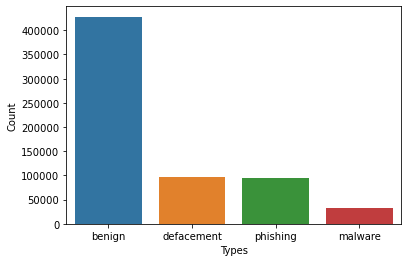

In [93]:
# URL type count plot
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');
plt.savefig("images/url_type_count")
plt.show()

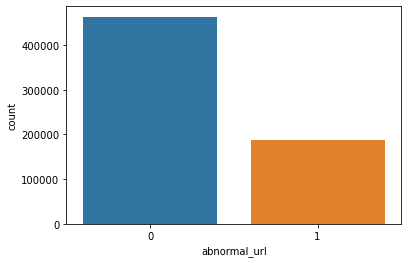

In [94]:
# abnormal_url plot
sns.countplot(x='abnormal_url', data=df);
plt.savefig("images/abnormal_url")
plt.show()


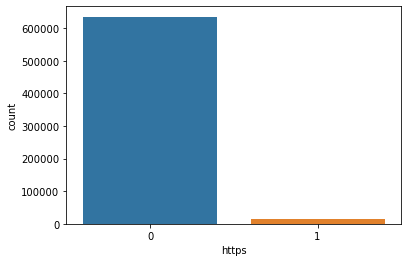

In [95]:
#https count
sns.countplot(x='https', data=df);
plt.savefig("images/https")
plt.show()

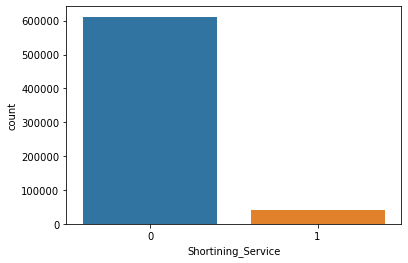

In [96]:
#Shortining_Service plot
sns.countplot(x='Shortining_Service', data=df);
plt.savefig("images/shortining_service")
plt.show()

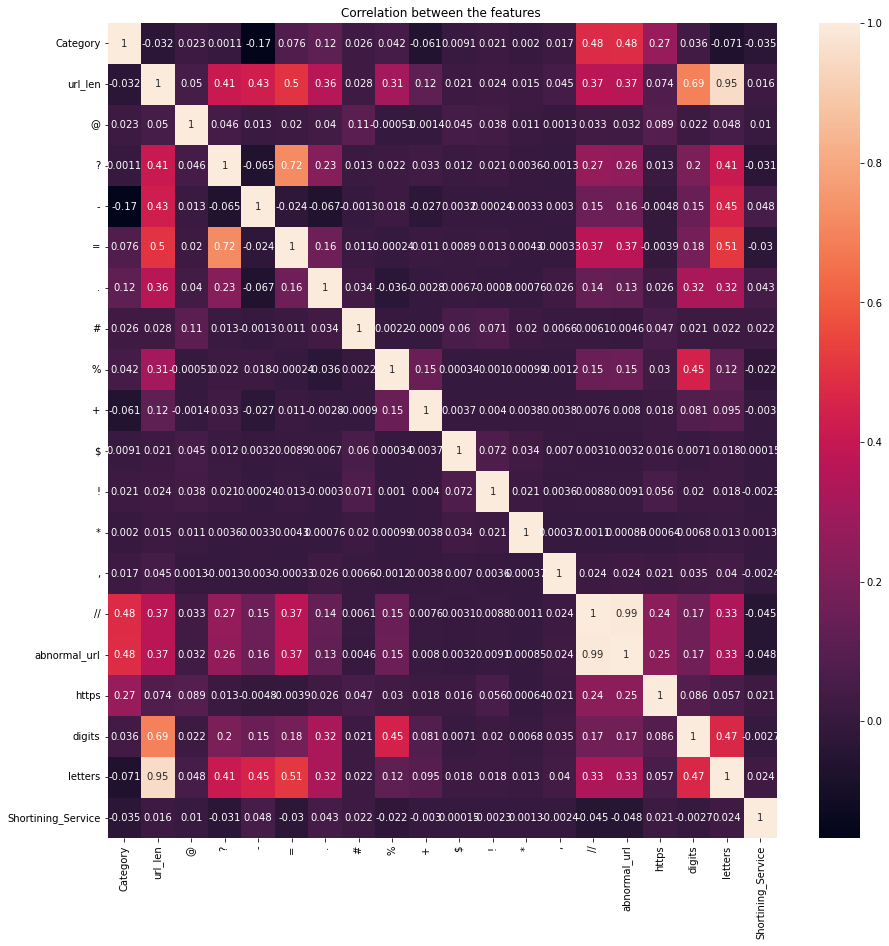

In [97]:
#Describe data and visualize it
df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation between the features ')
plt.savefig("images/feature_corr")
plt.show()

In [98]:
category_features = df.select_dtypes(include=['object', 'bool']).columns.values


Inference:


Inference
The campaign was more effective during summer months and dipped during other spring and fall holidays

###  Train/Test Split

With your data prepared, split it into a train and test set.

In [99]:
X = df.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = df['Category']
X

,url_len,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,Shortining_Service
0,16,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,13,0
1,35,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,29,0
2,31,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,25,0
3,84,0,1,1,4,2,0,0,0,0,0,0,0,1,1,0,7,60,0
4,235,0,1,1,3,2,0,0,0,0,0,0,0,1,1,0,22,199,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,39,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,12,21,0
651187,44,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,7,29,1
651188,38,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,30,1
651189,45,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,36,0


In [100]:
y

0         2
1         0
2         0
3         1
4         1
         ..
651186    2
651187    2
651188    2
651189    2
651190    2
Name: Category, Length: 651191, dtype: int64

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Modelling 

#### A Simple modeling

In [102]:
%%time
# Define the search space for Logistic Regression
log_reg_params = {'solver': ['liblinear', 'lbfgs'], 'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100], 'class_weight': [None, 'balanced']}
log_reg_model=""
# Grid search for Logistic Regression
log_reg_model = GridSearchCV(LogisticRegression(), log_reg_params, cv=5)
log_reg_model.fit(X_train, y_train)

log_reg_best_params = log_reg_model.best_params_


# Evaluate the logistic regression model on the train data
train_accuracy = log_reg_model.score(X_train, y_train)
test_accuracy = log_reg_model.score(X_test, y_test)
# Print the train  accuracy
print("Train accuracy: {:.2f}".format(train_accuracy))

print("Test accuracy: {:.2f}".format(test_accuracy))

In [ ]:
%%time
# Selected parameters assignement
log_reg_params = {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
start_time = time.time()
log_reg_model= LogisticRegression(**log_reg_params)
log_reg_model.fit(X_train,y_train)
end_time = time.time()
train_time = end_time - start_time
# Evaluate the logistic regression model on the train data
train_accuracy = log_reg_model.score(X_train, y_train)
test_accuracy = log_reg_model.score(X_test, y_test)

log_reg_model_result = pd.DataFrame({'Name': ['Logistic Regression'], 'Train Time': [train_time], 'Train Accuracy': [train_accuracy], 'Test Accuracy': [test_accuracy]})
results_df = pd.concat([results_df, log_reg_model_result])
# Print the train  accuracy
print("Train accuracy: {:.2f}".format(train_accuracy))
print("Test accuracy: {:.2f}".format(test_accuracy))

Inference:Logistic regression model is taking lot of time to executive I'll update the results later.

#### Score the Model

#### Logistic Regression Model

In [ ]:
# Evaluate the logistic regression model on the test data for solver='sag',max_iter=10000
accuracy = log_reg_model.score(X_test, y_test)

# Print the test accuracy
print("Test accuracy: {:.2f}".format(accuracy))


# Evaluate the logistic regression model on the test data solver='liblinear'
accuracy = log_reg_model.score(X_test, y_test)

# Print the test accuracy
print("Test accuracy: {:.2f}".format(accuracy))

In [ ]:
# Make predictions on the test data for LogRegModel
y_pred = log_reg_model.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a confusion matrix display
cmd = ConfusionMatrixDisplay(cm, display_labels=log_reg_model.classes_)

# Plot the confusion matrix
cmd.plot()

In [ ]:
# Make predictions on the test data
y_pred = log_reg_model.predict(X_test)


# Calculate the precision, recall, and F1 score
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# Print the performance metrics
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f1))

# Print the test accuracy
print("Test accuracy: {:.2f}".format(accuracy))

In [ ]:
#AUC ROC curve  for LogRegModel
logit_roc_auc = roc_auc_score(y_test,y_pred)
fpr, tpr, thresholds = roc_curve(y_test, log_reg_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('images/Log_ROC_Logistic Regression')
plt.show()
auc_score =roc_auc_score(y_test, log_reg_model.predict_proba(X_test)[:,1])
print("Logistic Regression AUC Score: {:.2f}".format(auc_score))

#### Comparitive modelling for Classifier

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  90.92%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     85565
           1       0.93      0.96      0.94     19319
           2       0.80      0.57      0.66     18805
           3       0.95      0.91      0.93      6550

    accuracy                           0.91    130239
   macro avg       0.90      0.85      0.87    130239
weighted avg       0.90      0.91      0.90    130239

             Confusion_matrix 


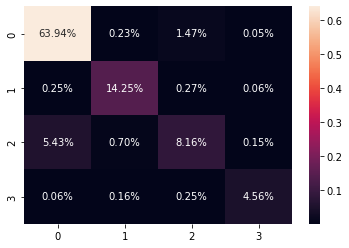

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  91.49%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.94      0.97      0.95     19319
           2       0.83      0.57      0.68     18805
           3       0.96      0.91      0.93      6550

    accuracy                           0.91    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.91      0.91    130239

             Confusion_matrix 


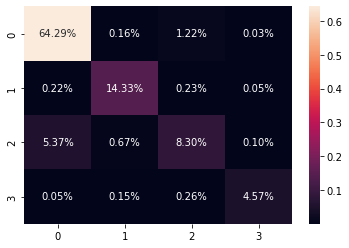

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 
Test Accuracy :  91.47%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.93      0.97      0.95     19319
           2       0.83      0.57      0.68     18805
           3       0.97      0.91      0.94      6550

    accuracy                           0.91    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.91      0.91    130239

             Confusion_matrix 


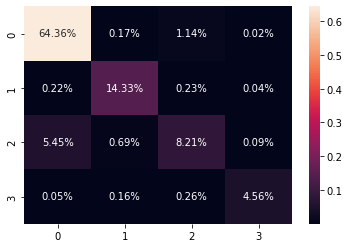

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 
Test Accuracy :  82.05%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.84      0.98      0.91     85565
           1       0.82      0.89      0.85     19319
           2       0.45      0.14      0.22     18805
           3       0.90      0.45      0.60      6550

    accuracy                           0.82    130239
   macro avg       0.75      0.62      0.64    130239
weighted avg       0.78      0.82      0.78    130239

             Confusion_matrix 


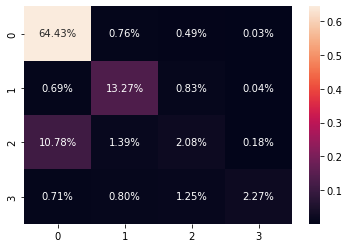

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._gb.GradientBoostingClassifier'> 
Test Accuracy :  85.84%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     85565
           1       0.84      0.95      0.89     19319
           2       0.83      0.20      0.33     18805
           3       0.89      0.75      0.81      6550

    accuracy                           0.86    130239
   macro avg       0.86      0.72      0.74    130239
weighted avg       0.86      0.86      0.83    130239

             Confusion_matrix 


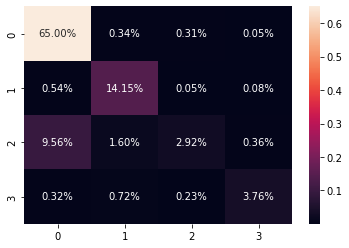

###################- End -###################
#############################################
######-Model => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Test Accuracy :  89.25%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     85565
           1       0.89      0.95      0.92     19319
           2       0.76      0.51      0.61     18805
           3       0.95      0.87      0.91      6550

    accuracy                           0.89    130239
   macro avg       0.88      0.83      0.84    130239
weighted avg       0.89      0.89      0.88    130239

             Confusion_matrix 


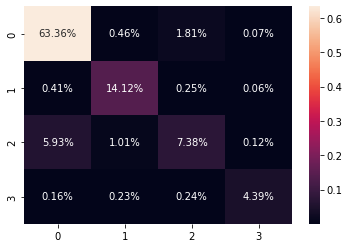

###################- End -###################
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  82.24%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.84      0.98      0.90     85565
           1       0.77      0.94      0.85     19319
           2       0.71      0.03      0.06     18805
           3       0.76      0.73      0.74      6550

    accuracy                           0.82    130239
   macro avg       0.77      0.67      0.64    130239
weighted avg       0.81      0.82      0.77    130239

             Confusion_matrix 


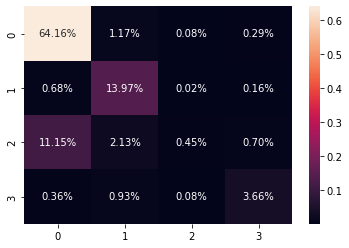

###################- End -###################
#############################################
######-Model => <class 'sklearn.naive_bayes.GaussianNB'> 
Test Accuracy :  77.03%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     85565
           1       0.61      1.00      0.76     19319
           2       0.58      0.02      0.04     18805
           3       0.42      0.34      0.38      6550

    accuracy                           0.77    130239
   macro avg       0.61      0.57      0.51    130239
weighted avg       0.75      0.77      0.71    130239

             Confusion_matrix 


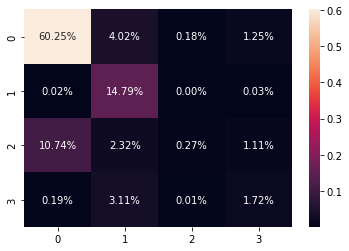

###################- End -###################


In [ ]:
models = [DecisionTreeClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,KNeighborsClassifier,SGDClassifier,
         GaussianNB]
accuracy_test=[]
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    print('\033[31m###################- End -###################\033[0m')

###  Model comparison

In [ ]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier','Extra Trees Classifier',
                                'AdaBoost Classifier','GradientBoostingClassifier','KNeighbors Classifier','SGD Classifier','Gaussian NB'],
                      "Accuracy":accuracy_test})
output

,Model,Accuracy
0,Decision Tree Classifier,0.909190
1,Random Forest Classifier,0.914864
2,Extra Trees Classifier,0.914711
3,AdaBoost Classifier,0.820492
4,GradientBoostingClassifier,0.858368
5,KNeighbors Classifier,0.892475
6,SGD Classifier,0.822449
7,Gaussian NB,0.770299


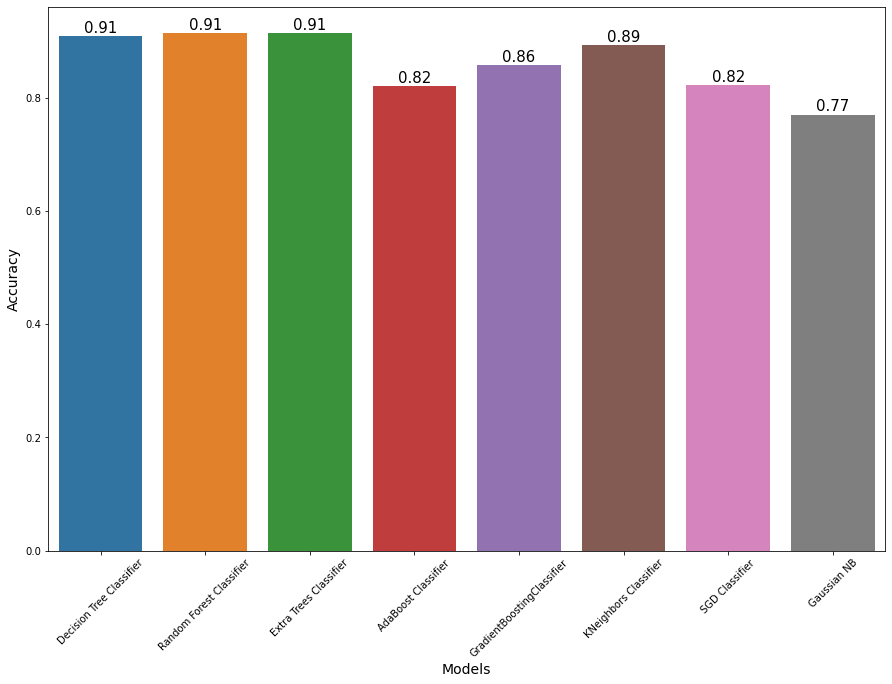

In [ ]:
plt.figure(figsize=(15, 10))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=45);
plt.ylabel("Accuracy", size=14)
plt.savefig('images/ModelAccuracyComparision')
plt.show()


### Conclusion:

Random Forest Classifier followed by Extra Tree Classifier were the best model for detecting malacious URL in the `malicious_phish.csv` dataset


### Next Step:

1. Improve above explored models, play with various hyper parameters.
2. Put the model to practical use
3. I wanted to  explore LSTM and Deep learning for the malacious URL problem